<a href="https://colab.research.google.com/github/bonly/AI/blob/main/train_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 描述
使用akshare获取A股sh600048的历史股票数据，并使用pytorch实现价格预测。

## 数据获取

### 使用akshare获取A股sh600048的历史股票数据。


In [ ]:
%pip install akshare

安装akshare包



In [5]:
import akshare as ak
import pandas as pd

start_date = "20240101"
end_date = "20250815"

# df = ak.stock_zh_a_hist(symbol="sh600048", period="daily", start_date=start_date, end_date=end_date, adjust="qfq")
df = ak.stock_zh_a_daily(symbol="sh600048", start_date=start_date, end_date=end_date, adjust="qfq")

display(df.head())
display(df.info())

,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2024-01-02,9.38,9.41,8.97,8.98,117278568.0,1.120367e+09,1.197044e+10,0.009797
1,2024-01-03,8.96,9.13,8.88,8.96,89972552.0,8.494157e+08,1.197044e+10,0.007516
2,2024-01-04,8.94,8.96,8.62,8.72,105095748.0,9.624206e+08,1.197044e+10,0.008780
3,2024-01-05,8.69,8.93,8.63,8.74,101885181.0,9.398792e+08,1.197044e+10,0.008511
4,2024-01-08,8.74,8.80,8.61,8.63,67455132.0,6.155500e+08,1.197044e+10,0.005635


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               393 non-null    object 
 1   open               393 non-null    float64
 2   high               393 non-null    float64
 3   low                393 non-null    float64
 4   close              393 non-null    float64
 5   volume             393 non-null    float64
 6   amount             393 non-null    float64
 7   outstanding_share  393 non-null    float64
 8   turnover           393 non-null    float64
dtypes: float64(8), object(1)
memory usage: 27.8+ KB


None

## 数据清洗


日期处理、特征选择和使用 PyTorch 进行标准化。

In [6]:
import torch
import numpy as np

# 将 'date' 列转换为日期时间格式并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 选择用于预测的特征，例如 'open', 'close', 'high', 'low', 'volume'
features = ['open', 'close', 'high', 'low', 'volume']
data = df[features].values

# 将 numpy 数组转换为 PyTorch 张量
data_tensor = torch.tensor(data, dtype=torch.float32)

# 使用 PyTorch 进行标准化处理 (MinMaxScaler 的 PyTorch 实现)
# 计算最小值和最大值
min_vals = torch.min(data_tensor, dim=0)[0]
max_vals = torch.max(data_tensor, dim=0)[0]

# 应用标准化公式: (x - min) / (max - min)
scaled_data = (data_tensor - min_vals) / (max_vals - min_vals)


# 打印处理后的数据形状和前几行
print("标准化后的数据形状:", scaled_data.shape)
print("\n标准化后的数据前5行:")
print(scaled_data[:5])

标准化后的数据形状: torch.Size([393, 5])

标准化后的数据前5行:
tensor([[0.4161, 0.3643, 0.4048, 0.4395, 0.1352],
        [0.3270, 0.3595, 0.3435, 0.4158, 0.0937],
        [0.3227, 0.3024, 0.3063, 0.3474, 0.1167],
        [0.2696, 0.3071, 0.2998, 0.3500, 0.1118],
        [0.2803, 0.2810, 0.2713, 0.3447, 0.0595]])


* dim=0

  * 维度上计算最小值。
  * 解释：

    * dim=0 表示在第一个维度（即列方向）上计算最小值。
    * 如果 data_tensor 是二维的，比如：
      ```
      [[1, 5, 3],
      [2, 4, 6]]
      ```
    那么 torch.min(data_tensor, dim=0) 会在每一列上找最小值，结果是 [1, 4, 3]。






* [0]

    * 含义：torch.min() 返回两个值：最小值和最小值的索引。[0] 表示只取最小值，不取索引。
    * 举例：
    如果 torch.min(data_tensor, dim=0) 返回 (tensor([1, 4, 3]), tensor([0, 1, 0]))，那么 [0] 就只取 tensor([1, 4, 3])。

代码的作用是：在 data_tensor 的第 0 维（即每一列）上找最小值，并把结果存储在 min_vals 中。

如果 data_tensor 是一维的，比如 [1, 3, 2, 5, 4]，那么 min_vals 就是 1。
如果 data_tensor 是二维的，比如上面的例子，那么 min_vals 就是 [1, 4, 3]。

## 创建用于 LSTM 模型训练的时间序列数据

In [7]:
# 创建序列数据
def create_sequences(data, seq_length):
    """
    创建时间序列的输入和输出序列。

    Args:
        data (torch.Tensor): 标准化后的数据张量。
        seq_length (int): 输入序列的长度（look-back window）。

    Returns:
        tuple: 包含输入序列和输出序列的张量。
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # 预测下一个交易日的开盘价
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# 设置序列长度 (可以根据需要调整)
seq_length = 60

# 创建训练数据和标签
X, y = create_sequences(scaled_data, seq_length)

# 打印序列数据形状
print("输入序列形状:", X.shape)
print("输出序列形状:", y.shape)

输入序列形状: torch.Size([333, 60, 5])
输出序列形状: torch.Size([333])


### 2/8拆分训练和检验数据

In [8]:
# 划分训练集和测试集
train_size = int(len(X) * 0.8)  # 80% 的数据用于训练
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 打印训练集和测试集的形状
print("训练集输入形状:", X_train.shape)
print("训练集输出形状:", y_train.shape)
print("测试集输入形状:", X_test.shape)
print("测试集输出形状:", y_test.shape)

训练集输入形状: torch.Size([266, 60, 5])
训练集输出形状: torch.Size([266])
测试集输入形状: torch.Size([67, 60, 5])
测试集输出形状: torch.Size([67])


## 构建PyTorch LSTM 模型

In [11]:
import torch.nn as nn

# 定义 LSTM 模型
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # batch_first=True 表示输入和输出张量的第一个维度是批次大小
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # hidden_cell 的形状应该是 (num_layers, batch_size, hidden_size)
        # 在这里，num_layers=1
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # input_seq 的形状是 (batch_size, seq_length, input_size)
        # 如果 batch_first=True, LSTM 期望的输入形状就是这样
        # lstm_out 的形状将是 (batch_size, seq_length, hidden_size)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # 我们只关心序列的最后一个时间步的输出
        # lstm_out[:, -1, :] 的形状是 (batch_size, hidden_size)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions # 返回所有批次的预测结果

# 设置模型参数
input_size = len(features)  # 输入特征的数量
hidden_layer_size = 100     # LSTM隐藏层大小
output_size = 1             # 预测输出大小 (开盘价)

# 实例化模型
model = StockPredictor(input_size, hidden_layer_size, output_size)

print("模型构建完成:")
print(model)

模型构建完成:
StockPredictor(
  (lstm): LSTM(5, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## 使用训练数据对模型进行了训练

In [12]:
import torch.optim as optim

# 定义损失函数和优化器
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 设置训练参数
epochs = 100  # 训练轮数

# 将模型设置为训练模式
model.train()

# 训练模型
print("开始训练模型...")
for i in range(epochs):
    # 清除之前的梯度
    optimizer.zero_grad()

    # 初始化隐藏状态，批量大小与输入数据匹配
    # X_train 的形状是 (batch_size, seq_length, input_size)
    batch_size = X_train.size(0)
    model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                        torch.zeros(1, batch_size, model.hidden_layer_size))


    # 进行前向传播
    y_pred = model(X_train)

    # 计算损失
    # y_pred 的形状是 (batch_size, output_size)，y_train 的形状是 (batch_size)
    # 使用 squeeze() 移除 y_pred 的最后一个维度以匹配 y_train 的形状
    single_loss = loss_function(y_pred.squeeze(), y_train)


    # 进行反向传播和优化
    single_loss.backward()
    optimizer.step()

    # 打印训练信息
    if i % 10 == 1:
        print(f'Epoch: {i:3} Loss: {single_loss.item():10.8f}')

print("模型训练完成。")

开始训练模型...
Epoch:   1 Loss: 0.08930177
Epoch:  11 Loss: 0.02523294
Epoch:  21 Loss: 0.01505627
Epoch:  31 Loss: 0.00843024
Epoch:  41 Loss: 0.00604849
Epoch:  51 Loss: 0.00541050
Epoch:  61 Loss: 0.00463778
Epoch:  71 Loss: 0.00433428
Epoch:  81 Loss: 0.00404979
Epoch:  91 Loss: 0.00385210
模型训练完成。


## 在测试集上评估了模型的性能，并进行了股票开盘价的预测。

In [13]:
# 将模型设置为评估模式
model.eval()

# 使用 torch.no_grad() 禁用梯度计算，以加速评估
with torch.no_grad():
    # 初始化隐藏状态，批量大小与测试数据匹配
    # X_test 的形状是 (batch_size, seq_length, input_size)
    batch_size_test = X_test.size(0)
    model.hidden_cell = (torch.zeros(1, batch_size_test, model.hidden_layer_size),
                        torch.zeros(1, batch_size_test, model.hidden_layer_size))

    # 在测试集上进行预测
    y_test_pred = model(X_test)

    # 计算测试集上的损失 (可选)
    test_loss = loss_function(y_test_pred.squeeze(), y_test)
    print(f"测试集上的损失: {test_loss.item():10.8f}")

# 由于预测结果是标准化的，我们需要将其反标准化回原始比例
# 注意：这里的反标准化需要使用原始数据的 min_vals 和 max_vals
# 我们需要确保这些值在测试阶段仍然可用。
# 为了简化，我们假设 min_vals 和 max_vals 已经被保存或者可以重新计算 (虽然重新计算不严谨)
# 在实际应用中，您应该保存训练时使用的 scaler 或 min/max 值
# 这里为了演示，我们使用之前计算的 min_vals 和 max_vals
# 预测的是开盘价，对应features列表中的第一个特征
predicted_opens_scaled = y_test_pred.squeeze()
# 获取开盘价特征的最小值和最大值
open_min = min_vals[0]
open_max = max_vals[0]

# 反标准化预测的开盘价
predicted_opens = predicted_opens_scaled * (open_max - open_min) + open_min

# 将实际测试集的开盘价也反标准化，以便进行比较
actual_opens_scaled = y_test
actual_opens = actual_opens_scaled * (open_max - open_min) + open_min


# 打印预测结果和实际结果的前几项
print("\n预测的开盘价 (前5项):")
print(predicted_opens[:5])
print("\n实际的开盘价 (前5项):")
print(actual_opens[:5])

测试集上的损失: 0.00054843

预测的开盘价 (前5项):
tensor([8.3234, 8.3196, 8.3006, 8.2796, 8.2671])

实际的开盘价 (前5项):
tensor([8.2900, 8.3100, 8.2600, 8.2600, 8.2800])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas

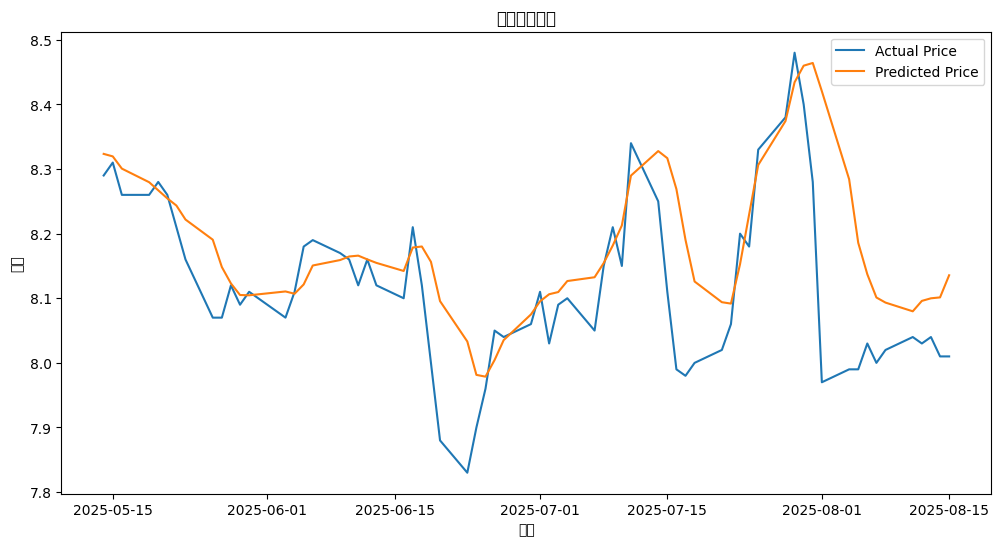

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 配置matplotlib支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 创建一个包含实际价格和预测价格的 DataFrame
# 为了正确对齐，我们需要测试集的日期索引
# 测试集的日期对应于原始df中从 train_size + seq_length 开始的日期
test_dates = df.index[train_size + seq_length:]

results_df = pd.DataFrame({'Actual': actual_opens.numpy(), 'Predicted': predicted_opens.numpy()}, index=test_dates)

# 绘制实际价格和预测价格的折线图
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
plt.title('股票价格预测')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.show()

In [16]:
# 安装wqy-zenhei字体
!apt-get update
!apt-get install -y fonts-wqy-zenhei

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main 

In [17]:
# 更新matplotlib字体缓存
import matplotlib.font_manager as fm
fm._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas

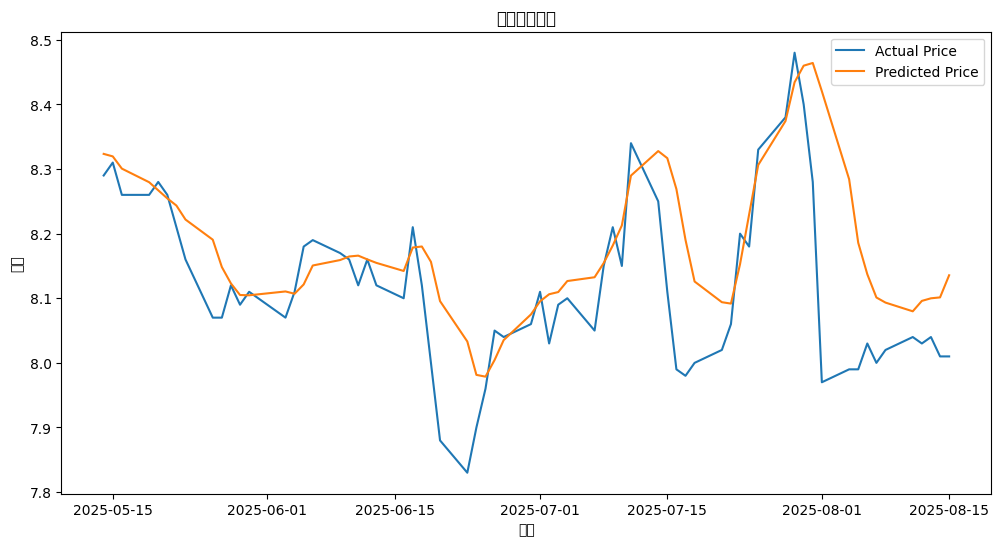

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# 删除字体缓存文件 (如果存在)
cache_dir = mpl.get_cachedir()
# 查找所有可能的fontlist.json文件版本
cache_files = [f for f in os.listdir(cache_dir) if f.startswith('fontlist-v') and f.endswith('.json')]
for cache_file in cache_files:
    cache_path = os.path.join(cache_dir, cache_file)
    try:
        os.remove(cache_path)
        print(f"Removed font cache file: {cache_path}")
    except OSError as e:
        print(f"Error removing file {cache_path}: {e}")


# 指定中文字体文件路径
chinese_font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

# 创建字体属性
font_prop = fm.FontProperties(fname=chinese_font_path)

# 尝试设置全局字体
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题


# 创建一个包含实际价格和预测价格的 DataFrame
# 为了正确对齐，我们需要测试集的日期索引
# 测试集的日期对应于原始df中从 train_size + seq_length 开始的日期
test_dates = df.index[train_size + seq_length:]

results_df = pd.DataFrame({'Actual': actual_opens.numpy(), 'Predicted': predicted_opens.numpy()}, index=test_dates)

# 绘制实际价格和预测价格的折线图
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
plt.title('股票价格预测') # 直接使用字符串，因为全局字体已设置
plt.xlabel('日期')      # 直接使用字符串，因为全局字体已设置
plt.ylabel('价格')      # 直接使用字符串，因为全局字体已设置
plt.legend()
plt.show()

In [19]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 查找所有可用的中文字体
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

chinese_fonts = [f for f in font_list if 'wqy' in f.lower() or 'ukai' in f.lower() or 'gkai' in f.lower() or 'simhei' in f.lower()]

print("Available Chinese fonts:")
for f in chinese_fonts:
    print(f)

# 尝试使用找到的字体名称进行配置
# 注意：您可能需要根据上面的输出选择一个合适的字体名称
# 例如，如果输出中有 '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttf'，
# 字体名称可能是 'WenQuanYi Zen Hei' 或 'wqy-zenhei'

# 假设我们找到了 'WenQuanYi Zen Hei' 这个名字，您可以尝试取消下面两行的注释
# mpl.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
# mpl.rcParams['axes.unicode_minus'] = False

# 然后重新运行绘图代码
# plt.figure(figsize=(12, 6))
# plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
# plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
# plt.title('股票价格预测')
# plt.xlabel('日期')
# plt.ylabel('价格')
# plt.legend()
# plt.show()

Available Chinese fonts:
/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc
